## Chapter 6: Conformal Prediction for Classification

### Why calibration is important

- You need to calibrate well, or your probability/regression outputs may not be meaningful
    - For example, it won't make sense if 20% of the people who you predict to have 1% chance of cancer actually have cancer
    - Without proper calibration, deciding on cutoffs may be difficult also. If your 50% isn't truly 50%, then what is the point?

### How to evaluate calibration

- There are a few ways to evaluate the calibration of your model?
    - Calibration Plot: Plot frequency of positives against mean predicted probability
    - Calibration Error: Reduce calibration evaluation to a single metric
        - Mean absolute distance between estimated probabilities and observed probabilities
    - Calibration metrics: Some of these include Expected Calibration Error, Log Loss, Brier Score (discussed in Chapter 3/4)
    - Cross validation

### Approaches to Classifier Calibration

#### Histogram Binning

- Not really an "algorithm" per se

- Procedure
    - Divide the predicted probabilities into bins/intervals 
    - For these same intervals, compute the observed proportions
    - Compute the ratio between the predicted and observed proportions
    - Adjust all probabilities within the intervals according to the adjustment ratio

- Some drawbacks 
    - Bins are kind of inflexible, so if miscalibration is non-linear, then you have problems
    - Binning causes information loss, because you are hard coding the boundaries between bins and calibrating only using bin averages
    - Sensitive to thresholds chosen
    - Discontinuous adjustments, even in adjacent bins
    - If your data distribution shifts, the bins may not generalise well to new data

#### Platt Scaling

- Procedure
    - Collect a labeled validation set or a holdout set that is distinct from the training data used to train the classifier
    - Use the classifier to generate the raw output scores or logits for the instances in the validation set
    - Fit a second logistic regression model on the validation set, treating the raw scores as the independent variable and the true class labels as the dependent variable
    - Once the logistic regression model has been trained, it can be used as a calibration function.
        - i.e. Given a new instance, the raw score produced by the classifier is input into the logistic regression model, which transforms it into a calibrated probability estimate.

- Idea is: you fit the predictions of a holdout set (that you know the true labels for) using another model

- Some drawbacks
    - You need a holdout validation set that the first model has not seen
    - Logreg assumption
    - If your holdout set contains some extreme values by chance, you may create a terrible calibration function unknowingly
    - Hard to map this to multiclass setting

#### Isotonic Regression

- Procedure
    - Train classifier on training set
    - Use the classifier to generate the raw output scores or probabilities for the instances in the validation set
    - Sort the instances and labels in the validation set based on the raw scores
        - i.e. [0.8, 0.5, 0.9, 0.2], [1, 1, 0, 0] ==> [0.2, 0.5, 0.8, 0.9], [0, 1, 1, 0]
    - Initialize the isotonic regression function as the identity function, where the initial predicted probabilities are equal to the raw scores
    - Iteratively update the isotonic regression function by adjusting the predicted probabilities to minimize the squared differences between the predicted probabilities and the target probabilities. This adjustment is subject to the constraint of non-decreasing probabilities.
        - In example above, we start with [0.2, 0.5, 0.8, 0.9]
        - 0.2 has label 0, so we may adjust this downwards
        - 0.5 has label 1, and 0.5 exceeds 0.2, so we may adjust this upwards such that it does not exceed 0.8
        - 0.8 has label 1, and 0.8 exceeds 0.5, so we may adjust this upwards such that it does not exceed 0.9
        - 0.9 has label 0, so we want to adjust it downwards such that it does not exceed 0.8
    - Once you have the isotonic regression, basically you have this piecewise line that maps predicted probabilities to the "correct" value, and ensures the piecewise line only increases

    - For more details, see your gitlab self-implementation of Isotonic Regression and PAVA algorithm

- Downsides
    - Overfitting possible
    - Sensitive to outliers
    - Limited flexibility
    - No multiclass support
    - Limited probabilistic interpretation
    - Inherent assumption that the new data can be perfectly ranked by the trained classifier

### Conformal prediction for classifier calibration

#### Venn-ABERS Conformal Prediction

- Procedure
    - For every new observation, append it to your "calibration set"
    - Use your trained classifier to form a prediction for your observation
    - Fit the isotonic regression twice, once assuming that your new observation is label 0, and another time assuming that your new observation is label 1
    - This gives you 2 calibrated probabilities; $p_0, p_1$
    - This forms the lower/upper bounds that your object belongs in label 1!

- Not only do you get the boundaries of your prediction, it can also be a monitoring tool for how quickly your model's uncertainty is deteriorating

- Practically, this can be combined into a single "adjusted" probability value for decision making 
$$\begin{aligned}
    p &= \frac{p_1}{1 - p_0 + p_1}
\end{aligned}$$

### Practical: ICP for Binary Classification

- https://github.com/PacktPublishing/Practical-Guide-to-Applied-Conformal-Prediction/blob/main/Chapter_06.ipynb

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from scipy.stats import rankdata

import openml

from sklearn.metrics import log_loss, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from  sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import label_binarize, LabelEncoder

import plotly.express as px


from nonconformist.base import ClassifierAdapter
from nonconformist.cp import IcpClassifier
from nonconformist.nc import NcFactory, ClassifierNc, InverseProbabilityErrFunc, MarginErrFunc

import warnings
warnings.filterwarnings('ignore')

#### Get data

In [29]:
datasets_df = openml.datasets.list_datasets(output_format="dataframe")
# Bank marketing dataset https://www.openml.org/d/1461
dataset = openml.datasets.get_dataset(1461)

# Print a summary
print(
    f"This is dataset '{dataset.name}', the target feature is "
    f"'{dataset.default_target_attribute}'"
)
print(f"URL: {dataset.url}")
print(dataset.description)

This is dataset 'bank-marketing', the target feature is 'Class'
URL: https://api.openml.org/data/v1/download/1586218/bank-marketing.arff
**Author**: Paulo Cortez, Sérgio Moro
**Source**: [UCI](https://archive.ics.uci.edu/ml/datasets/bank+marketing)
**Please cite**: S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. In P. Novais et al. (Eds.), Proceedings of the European Simulation and Modelling Conference - ESM'2011, pp. 117-121, Guimarães, Portugal, October, 2011. EUROSIS.       

**Bank Marketing**  
The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be (or not) subscribed. 

The classification goal is to predict if the client will subscribe a term deposit (variable y).

### Attribute information  
For m

#### Clean data

In [34]:
# openml API
X, y, categorical_indicator, attribute_names = dataset.get_data(
    dataset_format="array", target=dataset.default_target_attribute
)
df = pd.DataFrame(X, columns=attribute_names)
df["class"] = y

In [35]:
for cat_ind, col in zip(categorical_indicator, df.columns):
    # print(cat_ind, col)
    if cat_ind == True:
        df[col] = df[col].astype('category')

In [39]:
##Imbalanced
print(df['class'].mean())
df['class'].value_counts() 

0.11698480458295547


class
0    39922
1     5289
Name: count, dtype: int64

In [40]:
# Encode categorical columns using Label Encoder
le = LabelEncoder()
cat_columns = df.select_dtypes("category").columns

for col in cat_columns:
    df[col] = le.fit_transform(df[col])

#### Split DF (train, calibration, test)

In [41]:
X = df.drop('class', axis = 1)
y = df['class']

In [42]:
X_train_calib, X_test, y_train_calib, y_test = train_test_split(X, y, test_size=3000, random_state=42, stratify=y)
X_train, X_calib, y_train, y_calib = train_test_split(X_train_calib, y_train_calib, test_size=3000, random_state=42, stratify=y_train_calib)
print('Training set size {}'.format(len(y_train)))
print('Calibration set size {}'.format(len(y_calib)))
print('Test set size {}'.format(len(y_test)))

Training set size 39211
Calibration set size 3000
Test set size 3000


#### Model

In [43]:
# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [44]:
# make point predictions and obtain class scores on the calibration and test sets
y_pred_calib = model.predict(X_calib)
y_pred_score_calib = model.predict_proba(X_calib)

y_pred_test = model.predict(X_test)
y_pred_score_test = model.predict_proba(X_test)

In [45]:
print('Classification accuracy on the test: {}'.format(accuracy_score(y_test, y_pred_test)))
print('ROC AUC on the test set: {}'.format(roc_auc_score(y_test, y_pred_score_test[:,1])))

Classification accuracy on the test: 0.8903333333333333
ROC AUC on the test set: 0.7864764320030457


#### Compute non-conformity

In [49]:
def InverseProbabilityNC(predicted_score, y):
    '''
    predicted_score:
        - n x k array, where n is the number of obs in the training set plus the new observation, and k is the number of possible classes
    y:
        - (n+1,) array, containing outcomes of the n observations in the training set plus the assumed outcome for the 1 new observation 
    '''
    prob = np.zeros(y.size, dtype=np.float32)
  
    ## Looping across all n+1 observed/assumed outcomes
    for i, y_ in enumerate(y):
        
        ## Error handling: If outcome label falls outside of the prediction scope (i.e. outside the k possible outcomes defined in the prediction), store probability as 0
        if y_ >= predicted_score.shape[1]:  
            prob[i] = 0

        ## Otherwise, record the predicted probability of that particular class
        else:
            prob[i] = predicted_score[i, int(y_)]

    ## Hinge loss is computed as 1 - predicted probability of the correct class
    return 1 - prob

def compute_p_value(non_conformity_scores_train, non_conformity_scores_test):
    '''
    non_conformity_scores_train:
        - The nonconformity scores computed from the n observations in the training set
    
    non_conformity_scores_test:
        - The nonconformity score computed from the 1 observation we want to test
    '''
    p_values = []
    if not isinstance(non_conformity_scores_test, list):
        non_conformity_scores_test = [non_conformity_scores_test]

    for i, test_point_conformity_score in enumerate(non_conformity_scores_test):
        p_value = (np.sum(non_conformity_scores_train >= test_point_conformity_score) + 1) / (len(non_conformity_scores_train)+1)
        p_values.append(p_value)  
    return np.array(p_values)

In [50]:
non_conformity_scores_calibration = InverseProbabilityNC(y_pred_score_calib,y_calib)

In [59]:
new_observation_index = 0

non_conformity_scores_y_test_class_0 = 1 - y_pred_score_test[new_observation_index,0]
non_conformity_scores_y_test_class_1 = 1 - y_pred_score_test[new_observation_index,1]

non_conformity_scores_calib_plus_test_0 = np.append(non_conformity_scores_calibration, non_conformity_scores_y_test_class_0)
non_conformity_scores_calib_plus_test_1 = np.append(non_conformity_scores_calibration, non_conformity_scores_y_test_class_1)

# compute p-value of the test point twice, each time assigning potential label 0 and 1
p_value_class_0 = compute_p_value(non_conformity_scores_calib_plus_test_0, non_conformity_scores_y_test_class_0)
p_value_class_1 = compute_p_value(non_conformity_scores_calib_plus_test_0, non_conformity_scores_y_test_class_1)

print('p-value for class 0: {}, p-value for class 1: {}'.format(p_value_class_0,p_value_class_1))

p-value for class 0: [0.93737508], p-value for class 1: [0.00233178]


#### Plot nonconformity distribution

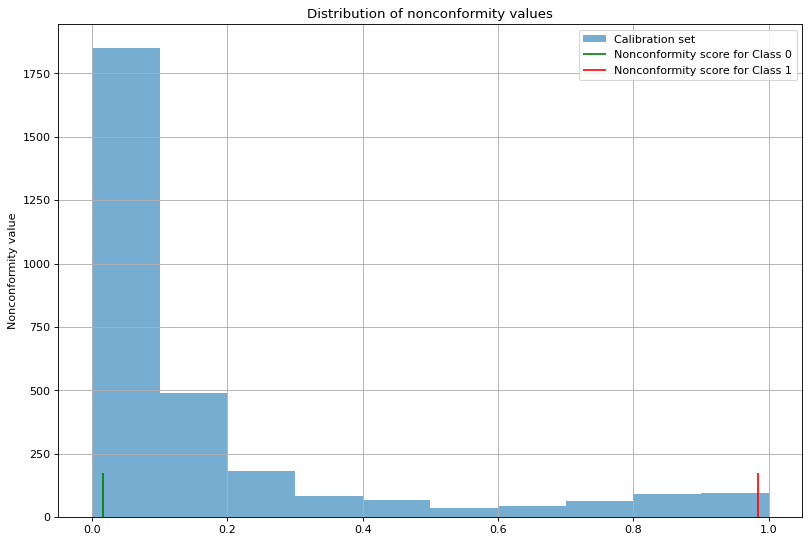

In [60]:
# plot distribution of nonconformity score for both situations

plt.figure(figsize=(12, 8), dpi=80)
plt.hist(np.sort(non_conformity_scores_calibration), label='Calibration set', alpha=0.6)
# single line
plt.vlines(x = non_conformity_scores_y_test_class_0, ymin = 0, ymax = 175, colors = 'green',
           label = 'Nonconformity score for Class 0')

plt.vlines(x = non_conformity_scores_y_test_class_1, ymin = 0, ymax = 175, colors = 'red',
           label = 'Nonconformity score for Class 1')

plt.grid(True)
plt.ylabel('Nonconformity value')
plt.title('Distribution of nonconformity values')

plt.legend( loc='upper right')
plt.show()

#### Prediction set for all values in test

In [23]:
def prediction_sets(X_train, y_train, X_calib, y_calib, X_test, y_test, model = LogisticRegression(), significance_level = 0.05):
    prediction_sets = []
    p_values_class_0 = []
    p_values_class_1 = []

    model.fit(X_train, y_train)

    # make point predictions and obtain class scores on the calibration and test sets
    y_pred_calib = model.predict(X_calib)
    y_pred_score_calib = model.predict_proba(X_calib)

    y_pred_test = model.predict(X_test)
    y_pred_score_test = model.predict_proba(X_test)

    for i,y in enumerate(y_test):
        # compute nonconformity scores for each test trying both potential labels - 0 & 1
        non_conformity_scores_y_test_class_0 = 1 - y_pred_score_test[i,0]
        non_conformity_scores_y_test_class_1 = 1 - y_pred_score_test[i,1]

        # compute p-value of the test point twice, each time assigning potential label 0 and 1
        p_value_class_0 = compute_p_value(non_conformity_scores_calib_plus_test_0, non_conformity_scores_y_test_class_0)
        p_value_class_1 = compute_p_value(non_conformity_scores_calib_plus_test_0, non_conformity_scores_y_test_class_1)

        p_values_class_0.append( p_value_class_0)
        p_values_class_1.append( p_value_class_1)

        if (p_value_class_0 > significance_level) and (p_value_class_1 > significance_level):
            prediction_sets.append([True,True])
        elif (p_value_class_0 > significance_level) and (p_value_class_1 <= significance_level):
            prediction_sets.append([True,False])
        elif (p_value_class_0 <= significance_level) and (p_value_class_1 >significance_level):
            prediction_sets.append([False,True])
        else:
            prediction_sets.append([False,False])

    return prediction_sets, p_values_class_0, p_values_class_1

In [24]:
predictions_test_sets, p_values_test_set_class_0, p_values_test_set_class_1 = prediction_sets(X_train, y_train, X_calib, y_calib, X_test, y_test, model = LogisticRegression(), significance_level = 0.05)

#### Compare with open source package

- The above implements ICP manually. Let's see if the open source package gives the same answer!

In [25]:
icp = IcpClassifier(ClassifierNc(ClassifierAdapter(LogisticRegression()), MarginErrFunc()))

# Fit the ICP using the proper training set
icp.fit(X_train, y_train)

# Calibrate the ICP using the calibraiton set
icp.calibrate(X_calib, y_calib)

# Produce predictions for the test set, with confidence 95%
prediction = icp.predict(X_test.values, significance=0.05)

In [27]:
for my_pred, package_pred in zip(predictions_test_sets, prediction):
    if all(my_pred != package_pred):
        raise ValueError('NOT EQUAL')
    
print('all good!')

all good!


### Resources

- Venn-ABERS NeurIPS paper: https://papers.nips.cc/paper_files/paper/2015/hash/a9a1d5317a33ae8cef33961c34144f84-Abstract.html
- Comparison of different calibration methods: http://www.diva-portal.org/smash/get/diva2:1603345/FULLTEXT01.pdf